## TP Optimisation II: Méthodes d'optimisation stochastique

### (Rendu: en format ipynb et en html)

### Nom(s): DKHISSI
### Prénom(s): Mahmoud
### Groupe: B1

## I. Minimisation stochastique d'une fonction déterministe


On s'intéresse au problème $\min f(x) =\max_{i=1\dots m}|a_i^Tx-b_i | = \max_{i=1\dots m} |(Ax-b)_i|.$ 

On suppose que $a_i$ est un vecteur colonne représentant la $i$eme ligne d'une matrice $A$ de taille $m \times n$ ($m=100, n=20$) , et les $b_i$ sont les composantes d'un second membre $b$ de taille $m$, ($1 \le i \le m$), $x$ un vecteur de taille $n$. Ces quantités sont générées une fois pour toutes à partir de distributions Gaussiennes de moyenne nulle et d'écart type identité.

**Question 1 :** Constuire $A$ et $b$. Proposer le calcul d'un sous-gradient en $x$ de $f$. On pourra utiliser la fonction findmax de Julia. 


In [3]:
#?findmax

In [10]:
using JLD

# Construction des données A  et b
m = 100;
n = 20 ; 
A = load("data.jld")["A"]
b = load("data.jld")["b"]
# init x
x = ones(n,1);

# Fonction calculant un sous-gradient en x de f
function subgrad(A,b,x) 
    fx = A*x-b
    i = findmax(abs.(fx))[2][1]
    g = sign(fx[i]) * A[i, :]
    return g
end


subgrad (generic function with 1 method)

**Question 2 :** Ce problème peut se reformuler comme un problème de programmation linéaire : $$(\mathcal{P}_{lp})\quad \left\{ \begin{array}{c} \min_{(x,R)\in \mathbb{R}^n\times \mathbb{R}} h(x,R)=R\\
s.c. \quad-R*e\leq A*x-b\leq R*e\end{array}\right.$$ avec $e=[1,\cdots,1]^T\in \mathbb{R}^m$. Résoudre le problème $(\mathcal{P}_{lp})$ en utilisant le solveur "GLPK" de la librairie JuMP. Plus d'informations sont disponibles ici :  http://www.juliaopt.org/JuMP.jl/latest/quickstart/

In [11]:
#using Pkg
#Pkg.add("JuMP"); 
#Pkg.add("GLPK")
using JuMP
using GLPK

# Définition du modèle
model = Model(GLPK.Optimizer)

# Définition des variables d'optimisation
@variable(model, x[1:n])
@variable(model, R)

# Définition de la fonctionnelle à minimiser
@objective(model, Min, R)

# Définition des contraintes
@constraint(model, c1[i=1:m], -R <= sum(A[i,j]*x[j] for j in 1:n) - b[i]);
@constraint(model, c2[i=1:m], R >= sum(A[i,j]*x[j] for j in 1:n) - b[i]);
      
# Résolution
optimize!(model)
        
# Résultats à optimalité
f_star = objective_value(model);
xstar = value.(x) 
Rstar = value(R)
println("The function value at the solution is: ",Rstar, " or ",findmax(abs.(A*xstar-b))[1])

The function value at the solution is: 1.7354496516663769 or 1.73544965166638


**Affichage attendu**:
```
The function value at the solution is: 1.7354496516663769 or 1.7354496516663798
```

**Question 3 :** Résoudre le problème en utilisant un algorithme de sous-gradient. Dans un premier temps vous utiliserez un sous-gradient exact (Question 1), puis vous introduirez un bruit artificiel qui suit une distribution normale de moyenne nulle et d'écart-type $3 e-1$.

**Question 4 :** Vous afficherez les courbes de convergence de $f_{best}^k-f_{star}$, avec $f_{star}$ obtenue à la Question 1. Donnez la valeur minimale de $f_{best}^k-f_{star}$.

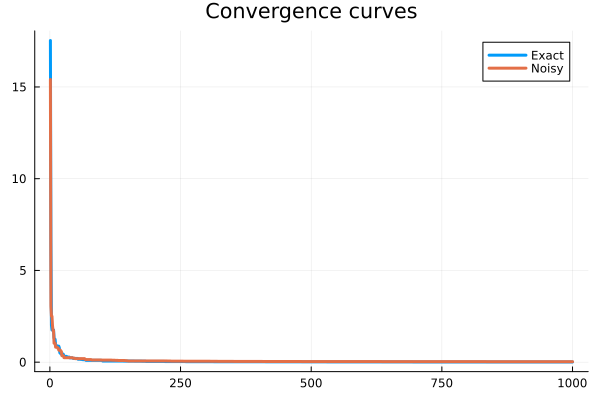

In [15]:
#Pkg.add("Plots")
using Plots

#Initialisation
x = zeros(n,1);
xb = x
i = 0;
fbest =1e10; # $f_{best}^0$: cas du sous-gradient exact
fbestp=1e10; # $f_{best}^0$: cas du sous-gradient bruité
histo =[];# Suite des itérés f_{best}^k-f_{star} pour le cas du sous-gradient exact
histop=[];# Suite des itérés f_{best}^k-f_{star}, pour le cas du sous-gradient bruité

#Niveau de bruit
noise_lvl=.3;

# Resolution
for i in 1:1000
    # Definition de alpha
    alpha = 1/i
    # Calcul du sous-gradient 
    g = subgrad(A,b,x)
    gb = subgrad(A,b,xb) + noise_lvl*randn(n,1)
    
    # Mise à jour des x
    x = x - alpha*g
    xb = xb - alpha*gb
    
    # Mise à jour des fbest
    
    fbest_i = findmax(abs.(A*x-b))[1];
    if fbest_i < fbest
        # Mise-à-jour de f_{best}
        fbest = fbest_i;
    end
    fbestp_i = findmax(abs.(A*xb-b))[1];
    if fbestp_i < fbestp
        # Mise-à-jour de fp_{best}
        fbestp = fbestp_i;
    end
    
    append!(histo,fbest-f_star)
    append!(histop,fbestp-f_star)
end

#Affichage des courbes de convergence
iter=1:1000;
hf=[histo,histop];
plot(hf,title="Convergence curves",label=["Exact" "Noisy"],lw=3)


## II. Minimisation stochastique d'une fonction stochatique



On s'intéresse au problème
$$\min_x [f(x) =\text{E} (\max_{i=1\dots m}|a_i^Tx-b_i |)].$$

On suppose que $a_i$ est un vecteur colonne représentant la $i$eme ligne d'une matrice $A$ de taille $m \times n$ ($m=100, n=20$) , et les $b_i$ sont les composantes d'un second membre $b$ de taille $m$, ($1 \le i \le m$), $x$ un vecteur de taille $n$. Ces quantités sont générées une fois pour toutes à partir de distributions Gaussiennes de moyenne connue $\bar{A}$ et $\bar{b}$ (non nécesairement nulle) et d'écart type identité.

**Question 5 :** Proposer deux fonctions d'évaluation de la fonction $f$ et d'un sous-gradient de $f$ basées sur des échantillons de taille $M$.


In [18]:
# Evaluation de f
function fvals(Abar,bbar,noise,xs,M) 
    # Abar, bbar : moyenne des données
    # noise : niveau de bruit 
    # xs : vecteur courant 
    # M: taille de l'échantillon
  m,n = size(Abar)
  f = 0;
  for i in 1:M
    f=f+findmax(abs.((Abar+noise*randn(m, n)) * xs - (bbar+noise*randn(m,1))))[1] 
  end
  f = (1/M)*f
  return f
end

# Evaluation d'un sous-gradient
function subgrads(Abar,bbar,noise,xs,M)
    # Abar, bbar : moyenne des données
    # noise : niveau de bruit 
    # xs : vecteur courant 
    # M: taille de l'échantillon
    m , n = size(Abar)
    g = zeros(n,1);
    for i in 1:M
        g=g+subgrad(Abar+noise*randn(m, n) , bbar+noise*randn(m,1), xs)
    end
    g=(1/M)*g
    return g

end

subgrads (generic function with 1 method)

**Question 6 :** Comparer les courbes de convergence du problème déterministe $$ \min_x f(x) = \max_{i=1\dots m}|\text{E} (a_i)^Tx-\text{E} (b_i) |,$$ et du problème stochastique obtenu avec $M=10,100,1000$ échantillons. Donnez la valeur minimale de $f$.

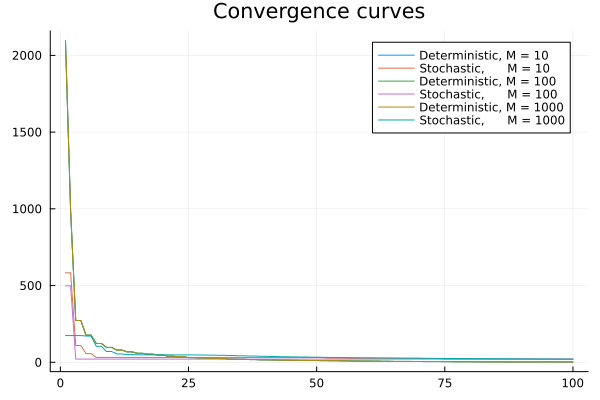

In [25]:
using Plots

# Données
Abar = load("data2.jld")["Abar"]
bbar = load("data2.jld")["bbar"]

function affiche(M)
    # Données
    m, n = 100, 20
    Abar = load("data2.jld")["Abar"]
    bbar = load("data2.jld")["bbar"]
    # x_0
    xd = zeros(n); # problème déterministe
    xs = xd; # problème stochastique
    
    # Bruit et échantillon
    noise = 4;
    
    fbestd = 1e10; # cas d'une résolution déterministe
    fbests = 1e10; # cas d'une résolution stochastique
    histod = []; # Suite des itérés f_{best}^k pour le cas d'une résolution déterministe
    histos = []; # Suite des itérés f_{best}^k pour le cas d'une résolution stochastique
        
    for i in 1:100 
        alpha = 1/i
        gd = subgrad(Abar, bbar, xd) 
        gs = subgrads(Abar, bbar, noise, xs, M) 
        xd = xd-alpha*gd
        xs = xs-alpha*gs
        fbestd_i = findmax(abs.(Abar * xd - bbar))[1];
        if fbestd_i < fbestd
            # Mise-à-jour de fd_{best}
            fbestd = fbestd_i;
        end
        fbests_i = fvals(Abar, bbar, noise, xs, M);
        if fbests_i < fbests
            # Mise-à-jour de fs_{best}
            fbests = fbests_i;
        end
        append!(histod, fbestd)
        append!(histos, fbests)
    end
    return [histod histos]
end
# Affichage 

iter = 1:100
hf = affiche.(10) # Pour le traçage, assurez-vous que les dimensions correspondent
plot(iter, hf, title = "Convergence curves", label = ["Deterministic, M = 10" "Stochastic,      M = 10"], lw = 1)
iter = 1:100
hf = affiche.(100) # Pour le traçage, assurez-vous que les dimensions correspondent
plot!(iter, hf, title = "Convergence curves", label = ["Deterministic, M = 100" "Stochastic,      M = 100"], lw = 1)
iter = 1:100
hf = affiche.(1000) # Pour le traçage, assurez-vous que les dimensions correspondent
plot!(iter, hf, title = "Convergence curves", label = ["Deterministic, M = 1000" "Stochastic,      M = 1000"], lw = 1)

**Question 7 :** Répéter les expériences et comparer les valeurs meilleurs valeurs de f obtenues ($f_{best}$) aprs un nombre fixé d'itérations. Donnez la valeur minimale de $f_{best}$

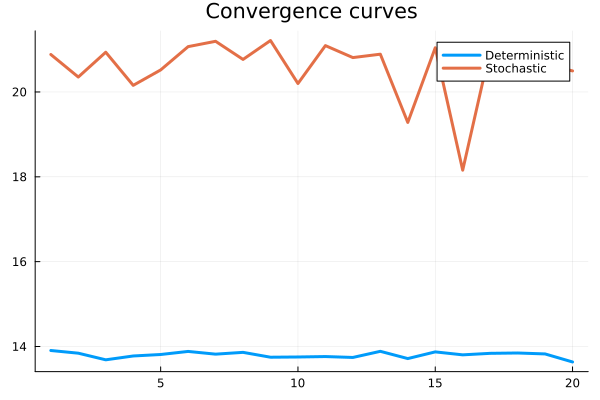

In [26]:
# Données
Abar = load("data2.jld")["Abar"]
bbar = load("data2.jld")["bbar"]

# x_0
xd = zeros(n,1); # résolution déterministe
xs = xd;  # résolution stochastique

# Bruit et echantillon
M  = 200;
noise  = 4;

#Nombre d'itérations
niter=100;
j = 0;
fbestd =1e10; # $f_{best}^0$: cas d'une résolution déterministe
fbests =1e10; # $f_{best}^0$: cas d'une résolution stochastique
fbesttd=[]; # f_{best} pour chaque expériences dans le cas d'une résolution déterministe
fbestts=[]; # f_{best} pour chaque expériences dans le cas d'une résolution stochastique

for nb=1:20
    # Répétition des expériences
    xd = zeros(n,1)
    xs = xd
    fbestd =1e10
    fbests =1e10
    for i in 1:100
        alpha = 1/i
        
        gd =subgrad(Abar,bbar,xd)
        xd = xd - alpha*gd
        fbestd_i = fvals(Abar,bbar,noise,xd,M)
        if fbestd_i < fbestd
            # Mise-à-jour de fd_{best}
            fbestd = fbestd_i;
        end
        
        gs = subgrads(Abar,bbar,noise,xs,M)
        xs = xs - alpha*gs
        fbests_i = fvals(Abar,bbar,noise,xs,M)
        if fbests_i < fbests
            # Mise-à-jour de fs_{best}
            fbests = fbests_i;
        end
        
    end
    append!(fbesttd, fbestd)
    append!(fbestts, fbests)
end

#Affichage

iter=1:20;
hf=[fbesttd,fbestts];
plot(iter,hf,title="Convergence curves",label=["Deterministic" "Stochastic"],lw=3)